In [1]:
import itertools
import pathlib
import pyam # version: 1.4.1.dev15+g3563b43

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

<IPython.core.display.Javascript object>

In [2]:
def check(df, v, ax=None):
    (
        df
        .filter(variable=v, region='World')
        .filter(Category=['C1', 'C2'])
        .filter(**{'R5 all': True})
        .plot
        .line(color='model', legend={'loc': 'outside right'}, cmap='tab20_r', ax=ax)
    )

# Load Data

In [3]:
data_path = pathlib.Path('../data')

In [4]:
paper_data = pyam.IamDataFrame(pd.read_csv(data_path / 'gidden_et_al_2022_ar6_reanalysis_data.csv'))

In [5]:
variables = ['Emissions|CO2']
ar6_data = pd.read_csv(data_path / 'AR6_Scenarios_Database_World_v1.0.csv')
ar6_data = ar6_data[ar6_data.Variable.isin(variables)]
ar6_data = pyam.IamDataFrame(ar6_data).filter(index=paper_data.index)

In [6]:
df = pyam.concat([paper_data, ar6_data])

In [7]:
df.load_meta(data_path / 'gidden_et_al_2022_ar6_reanalysis_meta.csv')

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading meta indicators


In [8]:
df.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'Emissions|CO2']

# Cumulative Sink

In [9]:
def make_cumulative_df(df, vold, vnew, offset=True):
    data = df.filter(variable=vold)
    if offset:
        data = data.offset(year=2020)
    return pyam.IamDataFrame(
        data
        .interpolate(range(2020, 2101))
        .filter(year=range(2020, 2101))
        .rename(variable={vold: vnew})
        .timeseries()
        .cumsum(axis=1)
    )

In [10]:
def create_cumulative_data(df, offset=True):
    variables = {
        'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect': 'Cumulative Carbon Sink - Indirect',
        'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct': 'Cumulative Carbon Sink - Direct',
    }
    
    dfs = []
    for vold, vnew in variables.items():
        dfs.append(make_cumulative_df(df, vold, vnew, offset=True))
    newdf = pyam.concat(dfs)
    newdf.load_meta(data_path / 'gidden_et_al_2022_ar6_reanalysis_meta.csv')
    return newdf

In [11]:
newdf = create_cumulative_data(df)

pyam.core - INFO: Reading meta indicators


### Visual Inspection

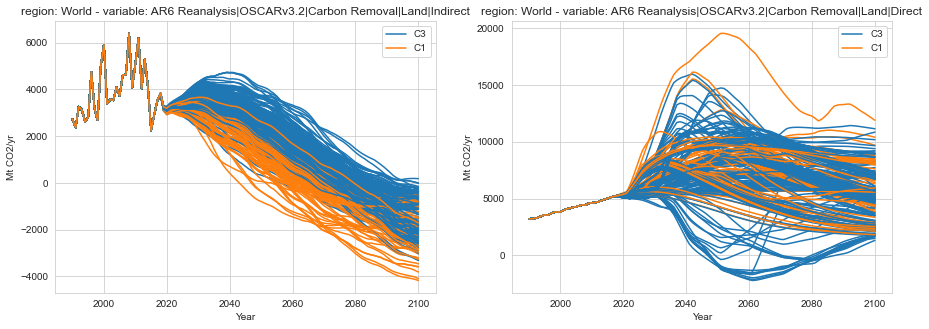

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
variables = ['AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect', 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct']
for ax, v in zip(axs, variables):
    (
        df
        .filter(variable=v, region='World')
        .filter(Category=['C1', 'C3'])
        .plot
        .line(color='Category', ax=ax)
    )

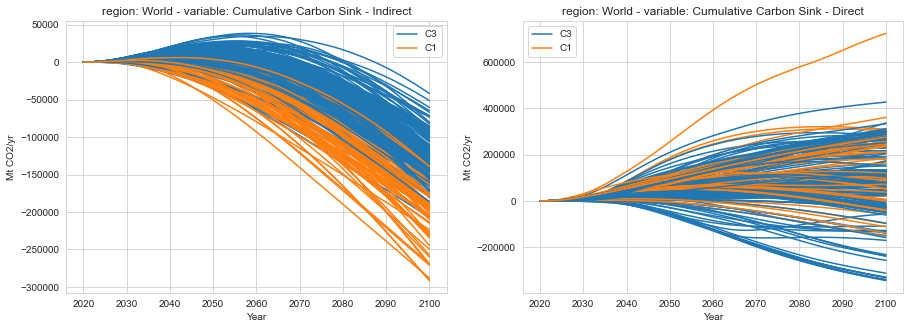

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
variables = ['Cumulative Carbon Sink - Indirect', 'Cumulative Carbon Sink - Direct']
for ax, v in zip(axs, variables):
    (
        newdf
        .filter(variable=v, region='World')
        .filter(Category=['C1', 'C3'])
        .plot
        .line(color='Category', ax=ax)
    )

pyam.core - INFO: Reading meta indicators


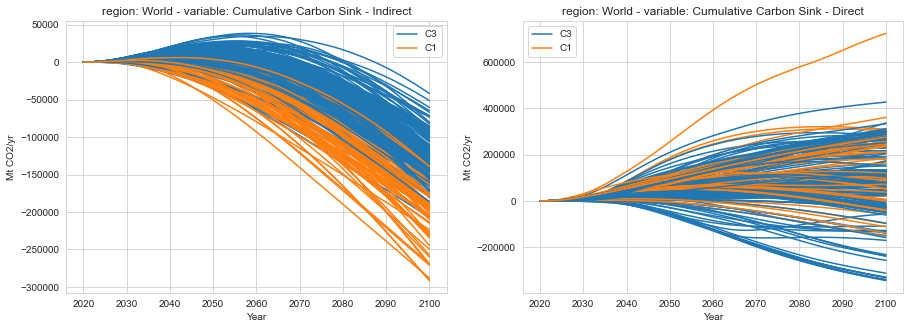

In [14]:
testdf = create_cumulative_data(df, offset=False)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
variables = ['Cumulative Carbon Sink - Indirect', 'Cumulative Carbon Sink - Direct']
for ax, v in zip(axs, variables):
    (
        testdf
        .filter(variable=v, region='World')
        .filter(Category=['C1', 'C3'])
        .offset(year=2020)
        .plot
        .line(color='Category', ax=ax)
    )

# Change in GHG Emissions from 2020

In [15]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
    'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
    'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
]

In [16]:
dfs = [
    df.filter(variable=v).offset(year=2020).rename(variable={v: f'Change in {v} from 2020'})
    for v in variables
]

In [17]:
data = pyam.concat(dfs)

In [18]:
newdf.append(pyam.concat(dfs), inplace=True)

# Cumulative GHG Emissions from 2020

In [19]:
dfs = [
    make_cumulative_df(df, v, f'Cumulative {v} from 2020', offset=False)
    for v in variables + ['Emissions|CO2']
]

In [20]:
newdf.append(pyam.concat(dfs), inplace=True)

# Write to disk

In [21]:
newdf.to_csv(data_path / 'additional_analysis_data.csv')

In [23]:
df.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'Emissions|CO2']

In [25]:
df['Category'].unique()

array([nan, 'C3', 'C5', 'C6', 'C7', 'C4', 'C1', 'C2', 'C8'], dtype=object)

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land'}, xlabel='Year', ylabel='Mt CO2/yr'>

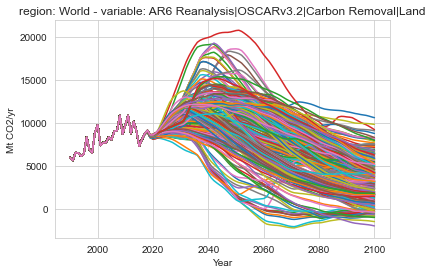

In [27]:
(
    df.filter(variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land', region='World')
    .filter(Category=['C1', 'C2', 'C3'])
    .plot
    .line()
)